In [1]:
import sys
print(sys.executable)

/home/javitrucas/miniconda3/envs/tfg/bin/python


In [2]:
import sys
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# Importaciones necesarias
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# Agregar la ruta de los scripts al sistema
import sys
sys.path.append(os.path.abspath("../scripts"))

# Importar el modelo y las clases de datasets
from scripts.model import MILModel
from data.datasets.SCStandardMILDataset import SCStandardMILDataset
from data.datasets.MCStandardMILDataset import MCStandardMILDataset
from data.datasets.FalseFrequencyMILDataset import FalseFrequencyMILDataset

/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
# Configuración general
DATA_DIR = "../data/datasets"  # Carpeta donde están los datasets
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
FEATURE_DIM = 128
POOLING_TYPE = "attention"  # Opciones: 'attention', 'mean', 'max'

# Parámetros específicos de los datasets
D = 10  # Dimensionalidad de los datos
NUM_BAGS = 100  # Número de bolsas
B = 5  # Número de instancias negativas por bolsa
POS_CLASS_PROB = 0.5  # Probabilidad de que una bolsa sea positiva
SEED = 42  # Semilla para reproducibilidad

In [5]:
# Crear instancias de los datasets
sc_dataset = SCStandardMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=POS_CLASS_PROB,
    train=True,
    seed=SEED
)

mc_dataset = MCStandardMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=POS_CLASS_PROB,
    train=True,
    seed=SEED
)

false_freq_dataset = FalseFrequencyMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=POS_CLASS_PROB,
    train=True,
    seed=SEED
)

# Crear dataloaders
sc_loader = DataLoader(sc_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=sc_dataset.collate_fn)
mc_loader = DataLoader(mc_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=mc_dataset.collate_fn)
false_freq_loader = DataLoader(false_freq_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=false_freq_dataset.collate_fn)

=== SCStandard Dataset ===
Bag Label: tensor(0)
Instance Labels: tensor([-1.,  0.,  0.,  0.,  0.,  0.])


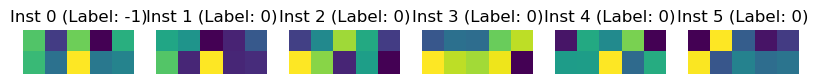

=== MCStandard Dataset ===
Bag Label: tensor(0)
Instance Labels: tensor([ 0.,  0.,  0.,  0.,  0., -1., -2., -2., -2.])


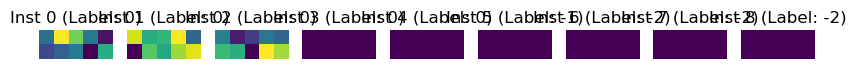

=== False Frequency Dataset ===
Bag Label: tensor(0)
Instance Labels: tensor([ 0.,  0.,  0.,  0.,  0., -1., -2., -2., -2., -2.])


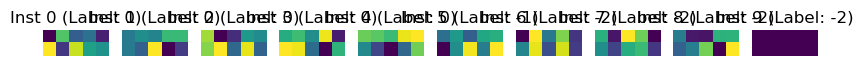

In [6]:
def visualize_bag(bag_data, bag_label, instance_labels):
    """
    Visualiza una bolsa de instancias junto con sus etiquetas.
    """
    print("Bag Label:", bag_label)
    print("Instance Labels:", instance_labels)
    plt.figure(figsize=(10, 5))
    for i, instance in enumerate(bag_data):
        plt.subplot(1, len(bag_data), i + 1)
        plt.title(f"Inst {i} (Label: {instance_labels[i].item():.0f})")
        plt.imshow(instance.numpy().reshape(2, -1), cmap="viridis")
        plt.axis("off")
    plt.show()

# Visualizar un ejemplo de cada dataset
print("=== SCStandard Dataset ===")
for bag_data, bag_label, instance_labels, adj_mat, mask in sc_loader:
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

print("=== MCStandard Dataset ===")
for bag_data, bag_label, instance_labels, adj_mat, mask in mc_loader:
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

print("=== False Frequency Dataset ===")
for bag_data, bag_label, instance_labels, adj_mat, mask in false_freq_loader:
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

In [25]:
# Configuración para SCStandard
D = 10  # ¡Ajusta esto según el dataset!
FEATURE_DIM = 64  # Ejemplo: reduce a 64 para SCStandard
POOLING_TYPE = "attention"

# Instanciar el modelo con las dimensiones correctas
model = MILModel(
    input_feature_dim=D,  # Usa D=10 para SCStandard
    feature_dim=FEATURE_DIM,
    pooling_type=POOLING_TYPE,
    dropout_prob=0.5
).to(DEVICE)

# Función de pérdida y optimizador
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [23]:
def train_model(loader, model, criterion, optimizer, epochs=NUM_EPOCHS):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for bag_data, bag_label, instance_labels, adj_mat, mask in loader:
            bag_data, bag_label = bag_data.to(DEVICE), bag_label.float().to(DEVICE)
            mask = mask.to(DEVICE) if mask is not None else None

            optimizer.zero_grad()
            predictions, _ = model(bag_data, mask=mask)
            loss = criterion(predictions.squeeze(), bag_label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Entrenar el modelo en el SCStandard Dataset
print("=== Entrenando en SCStandard Dataset ===")
train_model(sc_loader, model, criterion, optimizer)

=== Entrenando en SCStandard Dataset ===
Epoch 1/10, Loss: 14.6413
Epoch 2/10, Loss: 8.5852
Epoch 3/10, Loss: 6.8120
Epoch 4/10, Loss: 5.6587
Epoch 5/10, Loss: 4.3648
Epoch 6/10, Loss: 3.7810
Epoch 7/10, Loss: 3.4033
Epoch 8/10, Loss: 2.8577
Epoch 9/10, Loss: 2.2762
Epoch 10/10, Loss: 2.1233


In [24]:
def evaluate_model(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bag_data, bag_label, instance_labels, adj_mat, mask in loader:
            bag_data, bag_label = bag_data.to(DEVICE), bag_label.float().to(DEVICE)
            mask = mask.to(DEVICE) if mask is not None else None

            predictions, _ = model(bag_data, mask=mask)
            predicted_labels = (torch.sigmoid(predictions) > 0.5).float().squeeze()
            correct += (predicted_labels == bag_label).sum().item()
            total += bag_label.size(0)
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")

# Evaluar el modelo en el SCStandard Dataset
print("=== Evaluando en SCStandard Dataset ===")
evaluate_model(sc_loader, model)

=== Evaluando en SCStandard Dataset ===
Accuracy: 1.0000


In [ ]:
# Repetir el proceso para otros datasets
print("=== Entrenando en MCStandard Dataset ===")
train_model(mc_loader, model, criterion, optimizer)

print("=== Evaluando en MCStandard Dataset ===")
evaluate_model(mc_loader, model)

print("=== Entrenando en False Frequency Dataset ===")
train_model(false_freq_loader, model, criterion, optimizer)

print("=== Evaluando en False Frequency Dataset ===")
evaluate_model(false_freq_loader, model)